In [30]:
from image_feature_extractor.feature_extraction import extract_features 
from image_feature_extractor.feature_visualization import feature_vis
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
data_path = 'data/'
final_img_features, final_img_filepaths, total_features = extract_features(data_path, 'dinov2_large')
final_img_features.shape, len(final_img_filepaths), total_features.shape

total number of images:  4
total number of batched:  1


Using cache found in /Users/guro/.cache/torch/hub/facebookresearch_dinov2_main
100%|██████████| 1/1 [00:52<00:00, 52.17s/it]


((4, 1536), 4, torch.Size([4, 1369, 1536]))

In [32]:
total_features.shape

torch.Size([4, 1369, 1536])

['lion.jpeg', 'cart3.jpeg', 'cat.jpg', 'rtx1tglo.jpg']


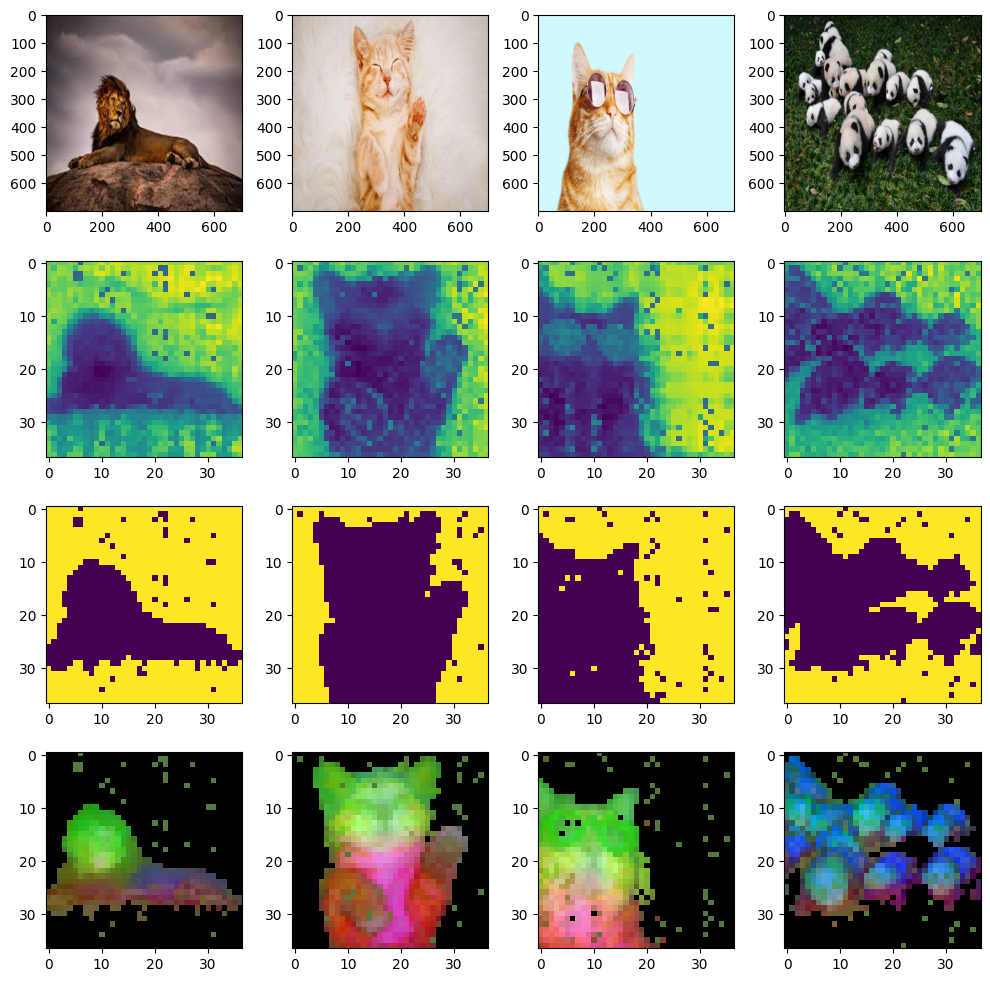

(5476, 3)

In [33]:
pca_feat = feature_vis(total_features, data_path) #visualize first four image
pca_feat.shape

## Testing

In [5]:
import torch
import os

In [6]:
dinov2_vitl14 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitl14')

Using cache found in /Users/guro/.cache/torch/hub/facebookresearch_dinov2_main


In [7]:
import requests
from PIL import Image
from torchvision import transforms
# transform = transforms.Compose([           
#                                 transforms.Resize(256),                    
#                                 transforms.CenterCrop(224),               
#                                 transforms.ToTensor(),                    
#                                 transforms.Normalize(                      
#                                 mean=[0.485, 0.456, 0.406],                
#                                 std=[0.229, 0.224, 0.225]              
#                                 )])


transform1 = transforms.Compose([           
                                transforms.Resize(520),
                                transforms.CenterCrop(518), #should be multiple of model patch_size                 
                                transforms.ToTensor(),                    
                                transforms.Normalize(mean=0.5, std=0.2)
                                ])

In [8]:
patch_size = dinov2_vitl14.patch_size # patchsize=14

#520//14
patch_h  = 520//patch_size
patch_w  = 520//patch_size

# feat_dim = 384 # vits14
# feat_dim = 768 # vitb14
feat_dim = 1024 # vitl14
# feat_dim = 1536 # vitg14

folder_path = "data/"
total_features  = []
with torch.no_grad():
  for img_path in os.listdir(folder_path):
    img_path = os.path.join(folder_path, img_path)
    img = Image.open(img_path).convert('RGB')
    img_t = transform1(img)
    
    features_dict = dinov2_vitl14.forward_features(img_t.unsqueeze(0))
    features = features_dict['x_norm_patchtokens']
    total_features.append(features)
total_features = torch.cat(total_features, dim=0)
total_features.shape

torch.Size([4, 1369, 1024])

In [9]:
total_features.shape

torch.Size([4, 1369, 1024])

In [10]:
patch_h = 518//patch_size
patch_w = 518//patch_size
feat_dim = total_features.shape[-1]
img_num = total_features.shape[0]
img_num, feat_dim, patch_w, patch_h

(4, 1024, 37, 37)

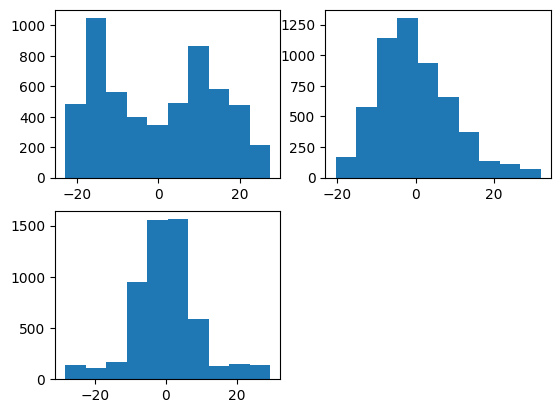

In [11]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# First PCA to Seperate Background
# sklearn expects 2d array for traning

total_features = total_features.reshape(img_num * patch_h * patch_w, feat_dim) #4(*H*w, 1024)

pca = PCA(n_components=3)
pca.fit(total_features)
pca_features = pca.transform(total_features)

# visualize PCA components for finding a proper threshold
# 3 histograms for 3 components
plt.subplot(2, 2, 1)
plt.hist(pca_features[:, 0])
plt.subplot(2, 2, 2)
plt.hist(pca_features[:, 1])
plt.subplot(2, 2, 3)
plt.hist(pca_features[:, 2])
plt.show()
plt.close()

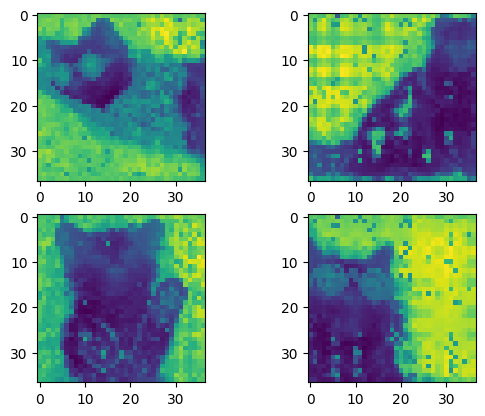

In [15]:
# min_max scale
pca_features[:, 0] = (pca_features[:, 0] - pca_features[:, 0].min()) / \
                     (pca_features[:, 0].max() - pca_features[:, 0].min())
#pca_features = sklearn.processing.minmax_scale(pca_features)

for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.imshow(pca_features[i*patch_h*patch_w : (i+1)*patch_h*patch_w, 0].reshape(patch_h, patch_w))

plt.show()

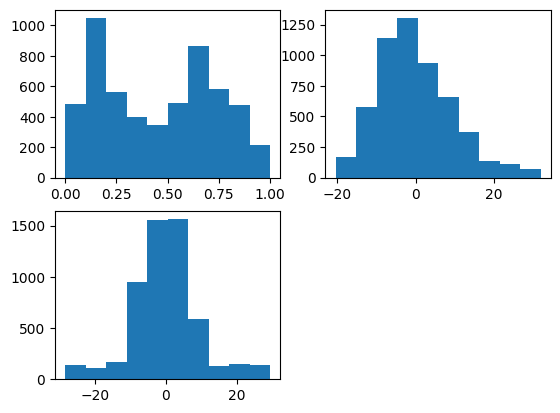

In [16]:
plt.subplot(2, 2, 1)
plt.hist(pca_features[:, 0])
plt.subplot(2, 2, 2)
plt.hist(pca_features[:, 1])
plt.subplot(2, 2, 3)
plt.hist(pca_features[:, 2])
plt.show()
plt.close()

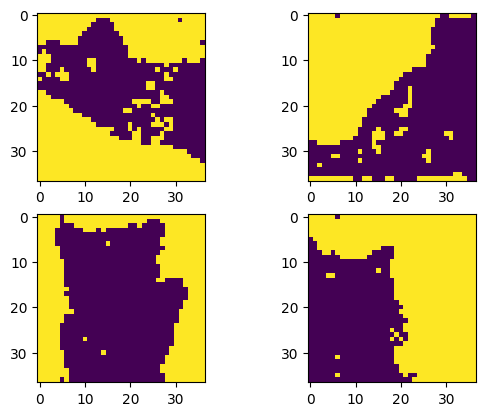

In [17]:
# segment/seperate the backgound and foreground using the first component
pca_features_bg = pca_features[:, 0] > 0.45 # from first histogram
pca_features_fg = ~pca_features_bg

# plot the pca_features_bg
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.imshow(pca_features_bg[i * patch_h * patch_w: (i+1) * patch_h * patch_w].reshape(patch_h, patch_w))
plt.show()


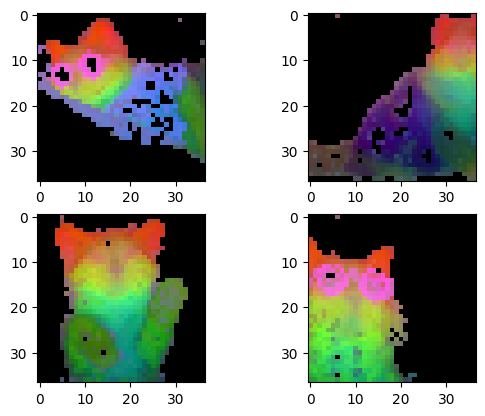

In [20]:
# 2nd PCA for only foreground patches
pca.fit(total_features[pca_features_fg]) 
pca_features_left = pca.transform(total_features[pca_features_fg])

for i in range(3):
    # min_max scaling
    pca_features_left[:, i] = (pca_features_left[:, i] - pca_features_left[:, i].min()) / (pca_features_left[:, i].max() - pca_features_left[:, i].min())

pca_features_rgb = pca_features.copy()
# for black background
pca_features_rgb[pca_features_bg] = 0
# new scaled foreground features
pca_features_rgb[pca_features_fg] = pca_features_left

# reshaping to numpy image format
pca_features_rgb = pca_features_rgb.reshape(4, patch_h, patch_w, 3)
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.imshow(pca_features_rgb[i])

plt.show()

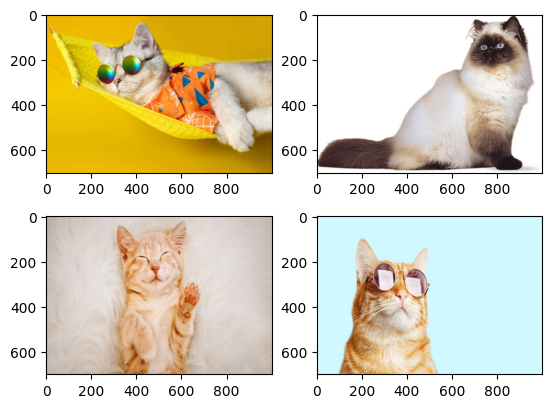

In [21]:
for i,img_path in enumerate(os.listdir(folder_path)):
  img_path = os.path.join(folder_path, img_path)
  img = Image.open(img_path).convert('RGB').resize((1000, 700))
  plt.subplot(2, 2, i+1)
  plt.imshow(img)
plt.show()
     